**The rotation of the markers seems to be off**


In this notebook the orientation and the position is analyzed

In [1]:
import pickle
import numpy as np
from parameter_estimator import ParameterEstimator
import utils
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
import cv2

In [47]:
# import nominal positions of markers
with open('points.p', 'rb') as f:
    pointlist = pickle.load(f)  # deserialize using load()

nominal_locations = {}
nominal_locations_rounded = {}
for i, point in enumerate(np.array(pointlist).T):
    nominal_locations[i+1] = np.concatenate((point[0:3], np.zeros(1), point[3:5]))
    nominal_locations_rounded[i+1] = np.around(nominal_locations[i+1], 4)
#     print(f"{i+1}: {nominal_locations[i+1]}")
    print(f"{i+1}: {nominal_locations_rounded[i+1]}\n")    

1: [1.932 0.    0.518 0.    0.262 0.   ]

2: [1.414 0.    1.414 0.    0.785 0.   ]

3: [0.518 0.    1.932 0.    1.309 0.   ]

4: [1.204 1.51  0.518 0.    0.262 0.898]

5: [0.882 1.106 1.414 0.    0.785 0.898]

6: [0.323 0.405 1.932 0.    1.309 0.898]

7: [-0.43   1.883  0.518  0.     0.262  1.795]

8: [-0.315  1.379  1.414  0.     0.785  1.795]

9: [-0.115  0.505  1.932  0.     1.309  1.795]

10: [-1.74   0.838  0.518  0.     0.262  2.693]

11: [-1.274  0.614  1.414  0.     0.785  2.693]

12: [-0.466  0.225  1.932  0.     1.309  2.693]

13: [-1.74  -0.838  0.518  0.     0.262  3.59 ]

14: [-1.274 -0.614  1.414  0.     0.785  3.59 ]

15: [-0.466 -0.225  1.932  0.     1.309  3.59 ]

16: [-0.43  -1.883  0.518  0.     0.262  4.488]

17: [-0.315 -1.379  1.414  0.     0.785  4.488]

18: [-0.115 -0.505  1.932  0.     1.309  4.488]

19: [ 1.204 -1.51   0.518  0.     0.262  5.386]

20: [ 0.882 -1.106  1.414  0.     0.785  5.386]

21: [ 0.323 -0.405  1.932  0.     1.309  5.386]



In [48]:
# import observations from file

# select observations file
observations_file_select = 6
observations_file_str_dict = {1: r'observation_files/obs_2007_gazebo_iiwa_stopping.bag_20230720-135812.p',  # works
                              2: r'observation_files/obs_2007_gazebo_iiwa_stopping.bag_20230720-135812_filtered.p',
                              4: r'observation_files/obs_2007_gazebo_.p',  # works
                              5: r'observation_files/obs_bag_with_lockstep_281023_2023-10-28-14-01-49_20231028-142947.p',
                              6: r'observation_files/obs_single_marker_2023-11-01-11-12-21_20231101-112227.p',
                              9: r'observation_files/observations_simulated_w_error_0mm_0deg_num24020231020_163148.p',
                              10: r'observation_files/observations_simulated_w_error_0.5mm_0.5deg_num24020231020_164948.p',
                              11: r'observation_files/observations_simulated_w_error_5mm_5e-05deg_num24020231027_095006.p',
                              12: r'observation_files/observations_simulated_w_error_7mm_5e-05deg_num24020231027_095120.p',
                              13: r'observation_files/observations_simulated_w_error_1mm_1deg_num24020231027_111510.p',
                              14: r'observation_files/observations_simulated_w_error_1mm_0.1deg_num24020231027_111600.p'}

observations_file = open(observations_file_str_dict[observations_file_select], 'rb')
observations = pickle.load(observations_file)
observations_file.close()
print(observations.keys())

dict_keys([2, 1, 4, 7, 5])


In [49]:
pe = ParameterEstimator()

theta = ParameterEstimator.dhparams["theta_nom"].astype(float)
d = ParameterEstimator.dhparams["d_nom"].astype(float)
r = ParameterEstimator.dhparams["r_nom"].astype(float)
alpha = ParameterEstimator.dhparams["alpha_nom"].astype(float)

marker_id = []

x = []
y = []
z = []
a = []
b = []
c = []

xn = []
yn = []
zn = []
an = []
bn = []
cn = []

ane = []
bne = []
cne = []

for marker in observations:
    if marker == 0 or marker>21: continue
    
    print(f'{marker} len: {len(observations[marker])}')
    for obs in observations[marker]:
        q = np.hstack((np.array(obs["q"]), np.zeros(1)))
        T_ = utils.H_rvec_tvec(obs["rvec"], obs["tvec"]) 
        # T_CM = pe.T_corr @ utils.H_rvec_tvec(obs["rvec"], obs["tvec"]) @ np.linalg.inv(pe.T_corr)
        T_corr2 = np.array([[0, 0, 1, 0], [-1, 0, 0, 0], [0, -1, 0, 0], [0, 0, 0, 1]]) 
        T_CM = T_corr2 @ T_ @ np.linalg.inv(T_corr2)

        # calculate nominal transforms
        T_08 = pe.get_T_jk(0, 8, q, theta, d, r, alpha)

        T_WM = pe.T_W0 @ T_08  @ T_CM 
        # utils.roundprint(T_WM)
        rvec, tvec = utils.mat2rvectvec(T_WM)
        marker_id.append(marker)
        x.append(tvec[0])
        y.append(tvec[1])
        z.append(tvec[2])
        a.append(rvec[0])
        b.append(rvec[1])
        c.append(rvec[2])
        
        xn.append(nominal_locations[marker][0])
        yn.append(nominal_locations[marker][1])
        zn.append(nominal_locations[marker][2])
        
        # before appending the nominal rotations, convert them into rodrigues
        rot_eul = [nominal_locations[marker][3], nominal_locations[marker][4], nominal_locations[marker][5]]
        rot_scipy = R.from_euler('xyz', rot_eul)
        rot_rodrigues = rot_scipy.as_rotvec()
        an.append(rot_rodrigues[0])
        bn.append(rot_rodrigues[1])
        cn.append(rot_rodrigues[2])
        
        ane.append(nominal_locations[marker][3])
        bne.append(nominal_locations[marker][4])
        cne.append(nominal_locations[marker][5])
    print(f'marker {marker}: rvec rodrigues - {rot_rodrigues}')
    print(f'marker {marker}: rvec eul - {rot_eul}')

        # int(f'{rvec} {tvec}')
        
df = pd.DataFrame()
df['x'] = x
df['y'] = y
df['z'] = z
df['a'] = a
df['b'] = b
df['c'] = c
df['marker_id'] = marker_id
df['xn'] = xn
df['yn'] = yn
df['zn'] = zn
df['an'] = an
df['bn'] = bn
df['cn'] = cn
df['ane'] = ane
df['bne'] = bne
df['cne'] = cne

2 len: 59
marker 2: rvec rodrigues - [0.    0.785 0.   ]
marker 2: rvec eul - [0.0, 0.7853981633974483, 0.0]
1 len: 27
marker 1: rvec rodrigues - [0.    0.262 0.   ]
marker 1: rvec eul - [0.0, 0.2617993877991494, 0.0]
4 len: 810
marker 4: rvec rodrigues - [-0.117  0.244  0.892]
marker 4: rvec eul - [0.0, 0.2617993877991494, 0.8975979010256552]
7 len: 28
marker 7: rvec rodrigues - [-0.235  0.187  1.784]
marker 7: rvec eul - [0.0, 0.2617993877991494, 1.7951958020513104]
5 len: 89
marker 5: rvec rodrigues - [-0.352  0.731  0.85 ]
marker 5: rvec eul - [0.0, 0.7853981633974483, 0.8975979010256552]


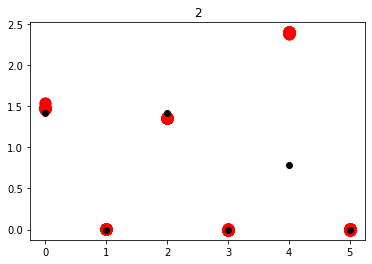

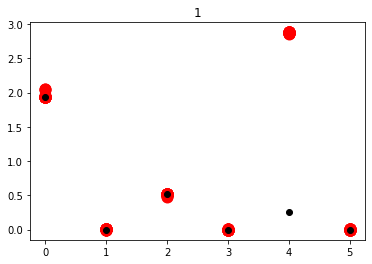

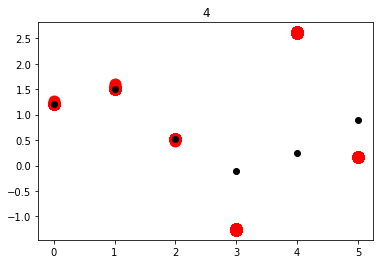

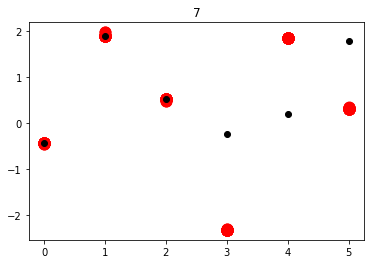

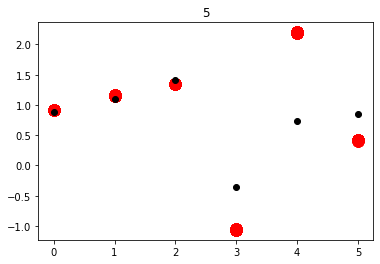

In [50]:
%matplotlib inline
coors = ['x', 'y', 'z', 'a', 'b', 'c']
for marker in observations:
    for x, coor in enumerate(coors):
        #print(f'x:{x}, coor:{coor}')
        measured_coordinate_vals = df[df['marker_id']==marker][coor].to_numpy()
        plt.scatter(np.repeat(x, len(measured_coordinate_vals)), measured_coordinate_vals, c='red', s=120)
        nominal_coordinate_vals = df[df['marker_id']==marker][coor+'n'].to_numpy()
        plt.scatter(x, nominal_coordinate_vals[-1], c='black')
        ane = df[df['marker_id']==marker]['ane'].to_numpy()[-1]
        #plt.scatter(3, ane, c='blue')
        bne = df[df['marker_id']==marker]['bne'].to_numpy()[-1]
        #plt.scatter(4, bne, c='blue')
        cne = df[df['marker_id']==marker]['cne'].to_numpy()[-1]
        #plt.scatter(5, cne, c='blue')
        plt.title(marker)
        plt.grid()
    plt.show()
    
## Die diagramme zeigen dass die Fehler in den Koordinaten x,y,z klein sind, aber a, b und c komplett falsch sind

if robot is in position q = (1, 1, 1, 1, 1, 1, 1) then the pose of the camera is
pos (3d)
x 0.453635
y 0.289806
z 1.12677
orient (quat)
x 0.000111717
y 0.140017
z 0.954031
w -0.264991

In [45]:

coors = ['x', 'y', 'z', 'a', 'b', 'c']
pose_meas_avg = np.zeros(6)
pose_nom = np.zeros(6)

tm = TransformManager()


for marker in observations:
    for x, coor in enumerate(coors):
        measured_coordinate_vals = df[df['marker_id']==marker][coor].to_numpy()
        pose_meas_avg[x] = measured_coordinate_vals.mean()
        nominal_coordinate_vals = df[df['marker_id']==marker][coor+'n'].to_numpy()
        pose_nom[x] = nominal_coordinate_vals[-1]
    print(f'marker {marker} (meas avg / nom)')
    np.set_printoptions(precision=3, suppress=True)
    print(pose_meas_avg)
    print(pose_nom)
    tm.add_transform(str(marker)+' n', "world", utils.H_rvec_tvec(pose_nom[3:6], pose_nom[0:3]))
    tm.add_transform(str(marker), "world", utils.H_rvec_tvec(pose_meas_avg[3:6], pose_meas_avg[0:3]))
    
    print('\n')

marker 2 (meas avg / nom)
[ 1.479  0.001  1.353 -0.001  2.397  0.001]
[1.414 0.    1.414 0.    0.785 0.   ]


marker 1 (meas avg / nom)
[ 1.949  0.001  0.514 -0.001  2.875  0.001]
[1.932 0.    0.518 0.    0.262 0.   ]


marker 4 (meas avg / nom)
[ 1.206  1.514  0.518 -1.258  2.611  0.17 ]
[ 1.204  1.51   0.518 -0.117  0.244  0.892]


marker 7 (meas avg / nom)
[-0.434  1.893  0.515 -2.313  1.846  0.314]
[-0.43   1.883  0.518 -0.235  0.187  1.784]


marker 5 (meas avg / nom)
[ 0.92   1.156  1.352 -1.059  2.198  0.414]
[ 0.882  1.106  1.414 -0.352  0.731  0.85 ]




[{'id': 4, 'rvec': [-2.261706666427429, 0.3956219075336571, 0.10506767249629897], 'tvec': [-0.10608463280266231, -0.2654725125867897, 1.5429129053543564], 't': 0, 'q': [0.39999201354370134, 1.29988799841911, 0.19999331207399426, 1.1998674242004241, 0.2999405617250366, 0.6002180023872059, 0.20002594794251305]}]


In [43]:
# pe = ParameterEstimator()
# 
# theta = ParameterEstimator.dhparams["theta_nom"].astype(float)
# d = ParameterEstimator.dhparams["d_nom"].astype(float)
# r = ParameterEstimator.dhparams["r_nom"].astype(float)
# alpha = ParameterEstimator.dhparams["alpha_nom"].astype(float)
# 
# singleobs = list_obs[0]
# 
# q = np.hstack((np.array(singleobs['q']), np.zeros(1)))
# 
# 
# # calculate nominal transform
# T_08 = pe.get_T_jk(0, 8, q, theta, d, r, alpha)
# 
# T_W8 = pe.T_W0 @ T_08
# tw8str = utils.roundprint(T_W8, 'string')
# 
# 
# rvec, tvec = utils.mat2rvectvec(T_W8)
# myrot = R.from_matrix(T_W8[0:3, 0:3])
# myquat = myrot.as_quat()
# print(f'Check camera pose with Rviz:\npos:  {tvec}\nquat: {myquat}\n')
# 
# T_CM = utils.H_rvec_tvec(singleobs["rvec"], singleobs["tvec"])
# T_corr2 = np.array([[0, 0, 1, 0], [-1, 0, 0, 0], [0, -1, 0, 0], [0, 0, 0, 1]]) 
# T_CM = T_corr2 @ T_CM @ np.linalg.inv(T_corr2)
# 
# tcmstr = utils.roundprint(T_CM, 'string')
# print(f'T_CM:\n{tcmstr}')
# 
# T_WM = T_W8 @ T_CM
# 
# twmstr = utils.roundprint(T_WM, 'string')
# print(f'T_WM:\n{twmstr}')
# 
# rvec, tvec = utils.mat2rvectvec(T_WM)
# print(f'4 identified: {tvec} {rvec}')
# 
# print('4 nominal: [1.2045 1.5104 0.5176] [0.     0.2618 0.8976]')
# 
# print('TCM should be:')
# T_CM_supposed = np.linalg.inv(T_W8) @ utils.H_rvec_tvec([0, 0.2618, 0.8976], [1.2045, 1.5104, 0.5176])
# utils.roundprint(T_CM_supposed)

In [8]:
from pytransform3d.plot_utils import make_3d_axis
import pytransform3d.transformations as tf
import pytransform3d.rotations as rot
from pytransform3d.transform_manager import TransformManager

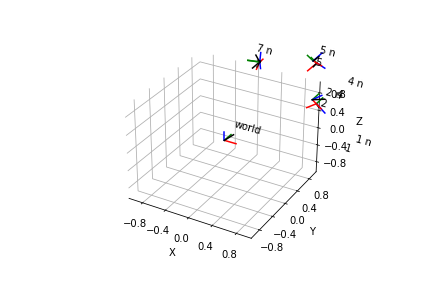

In [46]:
%matplotlib widget

ax = tm.plot_frames_in("world", s=0.2)
plt.show()


In [10]:
# T_WC = tf.transform_from(rot.passive_matrix_from_angle(1, 0.3), np.array([1,1,1]), strict_check=True)
# 1: axis y - rotation by -0.3 rad around axis y

In [11]:
# tm = TransformManager()
# tm.add_transform("camera", "world", T_WC)
# 
# for id,(rvec,tvec) in enumerate(zip(rvecs,tvecs)):
#     T_CM = tf.transform_from(rot.matrix_from_compact_axis_angle(rvec.flatten()), tvec)
#     T_corrector = np.array([  [ 0,  0, 1, 0],
#                                [ -1, 0, 0, 0],
#                                [ 0,  -1, 0, 0],
#                                [ 0, 0, 0, 1]])
#     tm.add_transform("marker"+str(id), "camera", T_corrector @ T_CM @ np.linalg.inv(T_corrector))
#     
# # ee2object = tm.get_transform("end-effector", "object")



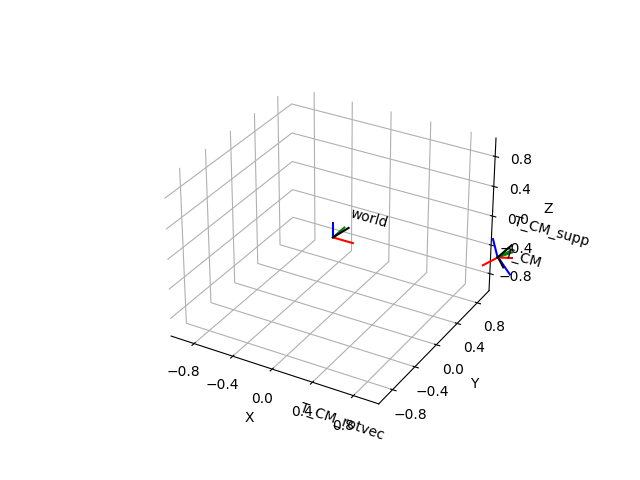

In [12]:
%matplotlib widget
ax = tm.plot_frames_in("world", s=0.2)
# ax.set_xlim((-0.25, 3))
# ax.set_ylim((-0.25, 3))
# ax.set_zlim((-0.25, 3))
# ax.scatter([2.4575, 2.5353, 2.2915], [0, 0.9822, 0.8877], [1.7207, 1.2679, 1.7207], c="black")
# ax.scatter([2.7189], [0], [1.2679], c="purple")
plt.show()

In [13]:
def scatter_on_line(points_vec):
    for points in points_vec:
        plotrange = np.arange(len(points))
        plt.scatter(plotrange, points)
    plt.show()

coor = 'a'
for marker in observations:
    nominal_coordinate_val = df[df['marker_id']==marker][coor+'n'].to_numpy()
    measured_coordinate_val = df[df['marker_id']==marker][coor].to_numpy()

    scatter_on_line([nominal_coordinate_val, measured_coordinate_val])

ValueError: s must be a scalar, or float array-like with the same size as x and y